Test code to compare quantification accuracy when including additional incomplete isoforms



In [1]:
import glob

import pandas as pd
import numpy as np

%load_ext rpy2.ipython

In [2]:
truth_t_infile = '../../run/annotations/mixture_concentrations.tsv'

In [3]:
number_reads = 500000
truth_t = pd.read_table(truth_t_infile, sep='\t', index_col=0)
truth_t.columns = ['Length', 'MXA', 'MXB']
print(truth_t.head())

truth_g = truth_t.copy()
truth_g = truth_g[['MXA', 'MXB']]


print(truth_t.head())


truth_g['gene_id'] = ["_".join(x.split("_")[0:2]) for x in truth_g.index]
truth_g = pd.DataFrame(truth_g.groupby('gene_id').sum())
truth_g.index.name = 'ID'
print(truth_g.head(10))


truth_t2 = truth_t.copy()
truth_t2.columns = ['Length', 'transcript_truth', 'transcript_truthMXB']
print(truth_t2.head(10))

truth_g2 = truth_g.copy()
truth_g2.columns = ['gene_truth', 'gene_truthMXB']
print(truth_g2.head(10))

print(sum(truth_t['MXA']))
print(sum(truth_t2['transcript_truth']))
print(sum(truth_g2['gene_truth']))

          Length          MXA          MXB
ID                                        
R1_11_1      703   161.132812     5.035400
R1_11_2      785    80.566406    10.070801
R1_13_1     1940  5156.250000  2578.125000
R1_13_2      698  2578.125000  5156.250000
R1_101_1     719    10.070801     1.258850
          Length          MXA          MXB
ID                                        
R1_11_1      703   161.132812     5.035400
R1_11_2      785    80.566406    10.070801
R1_13_1     1940  5156.250000  2578.125000
R1_13_2      698  2578.125000  5156.250000
R1_101_1     719    10.070801     1.258850
                 MXA           MXB
ID                                
R1_101     15.106201      1.888275
R1_102     15.106201      0.944138
R1_103    966.796875    483.398438
R1_11     241.699219     15.106201
R1_12      30.212402     60.424805
R1_13    7734.375000   7734.375000
R1_14     483.398438    241.699219
R1_21   30937.500000  30937.500000
R1_22     483.398438     30.212402
R1_23      15

In [4]:
incomplete_t_infiles = glob.glob('../../run/*/add_models/3prime/*_neat-A_subset/quant.sf')
incomplete_t_infiles.extend(glob.glob('../../run/*/add_models/3prime/*_neat-A_subset/abundance.h5.tsv'))
#skip_exon_g_infiles = glob.glob('../../run/*/add_models/skip_exons/*/genes.tsv.gz')

In [6]:
final_t_df = pd.DataFrame()

for infile in incomplete_t_infiles:
    parameters = infile.split("/")[-2]
    
    fraction = parameters.split("_")[0]
    iteration = parameters.split("_")[1]
    
    quantifier = infile.split("/")[-5].split(".")[0]
    
    tmp_df = pd.read_table(infile, sep="\t", index_col=0)
    
    if quantifier == 'kallisto':
        tmp_df.columns=['Length', 'EffectiveLength', 'NumReads', 'TPM']
    else:
        tmp_df.columns=['Length', 'EffectiveLength', 'TPM', 'NumReads']
        
    tmp_df = pd.merge(tmp_df, truth_t, left_index=True, right_index=True, how='left')

    tmp_df.fillna(0, inplace=True)
    tmp_df['fraction'] = fraction
    tmp_df['quantifier'] = quantifier
    tmp_df['iteration'] = iteration

    # need to merge in info from info infile
    info_infile = '../../run/sequins/add_models/3prime/transcripts_%s_%s.gtf.gz.tsv' % (
        fraction, iteration)
    info_df = pd.read_table(info_infile, sep='\t', index_col=0)    
    
    tmp_df = pd.merge(tmp_df, info_df, left_index=True, right_index=True, how='left')
    
    tmp_df['3prime_model'] = [1 if '3prime' in x else 0 for x in tmp_df.index]
    tmp_df['t_id'] = ["_".join(x.split("_")[0:3]) for x in tmp_df.index]
    tmp_df['g_id'] = ["_".join(x.split("_")[0:2]) for x in tmp_df.index]
    
    # need to make temp transcript and gene-level truth dataframes to
    # convert concentration to counts
    
    tmp_truth_t2 = truth_t2.copy()
    tmp_truth_g2 = truth_g2.copy()
    
    number_reads = sum(tmp_df['NumReads'])    
    tmp_df['MXA'] = (tmp_df['MXA'] / sum(tmp_df['MXA'])) * number_reads
    
    tmp_truth_t2['transcript_truth'] = (tmp_truth_t2['transcript_truth'] /
                                  sum(tmp_truth_t2['transcript_truth'])) * number_reads
    tmp_truth_g2['gene_truth'] = (tmp_truth_g2['gene_truth'] / 
                                  sum(tmp_truth_g2['gene_truth'])) * number_reads
    
    tmp_df = pd.merge(tmp_df, tmp_truth_t2, left_on='t_id', right_index=True, how='left')
    tmp_df = pd.merge(tmp_df, tmp_truth_g2, left_on='g_id', right_index=True, how='left')

    t_count_incomplete = pd.DataFrame(tmp_df.groupby('t_id')['3prime_model'].sum())
    t_count_incomplete.columns = ['count_3prime_t']
    
    g_count_incomplete = pd.DataFrame(tmp_df.groupby('g_id')['3prime_model'].sum())
    g_count_incomplete.columns = ['count_3prime_g']
    
    tmp_df = pd.merge(tmp_df, t_count_incomplete, left_on='t_id', right_index=True)
    tmp_df = pd.merge(tmp_df, g_count_incomplete, left_on='g_id', right_index=True)
    tmp_df['t_3prime'] = tmp_df['count_3prime_t'] > 0
    tmp_df['g_3prime'] = tmp_df['count_3prime_g'] > 0
    
    kmers_infile = '../../run/sequins/add_models/3prime/transcripts_%s_%s_transcript_kmers.tsv' % (
    fraction, iteration)

    kmers_df = pd.read_table(kmers_infile, sep='\t', index_col=0)
    tmp_df = pd.merge(tmp_df, kmers_df, left_index=True, right_index=True)

    final_t_df = pd.concat((final_t_df, tmp_df))


final_t_df['id'] = final_t_df.index

final_t_df['difference'] = np.log10(final_t_df['NumReads']+1) - np.log10(final_t_df['MXA']+1)

final_t_df['absolute_difference'] = abs(final_t_df['difference'])

final_t_df['relative_absolute_difference'] = final_t_df['absolute_difference'] / np.log10(final_t_df['MXA'] +1)

print(final_t_df.shape)


(87120, 30)


In [7]:
print(final_t_df.shape)
final_t_df = final_t_df[~final_t_df['g_id'].isin(['R1_11', 'R1_21', 'R2_14', 'R2_26'])]
print(final_t_df.shape)

(87120, 30)
(82377, 30)


In [8]:
print(set(final_t_df['quantifier']))

{'kallisto', 'sailfish', 'salmon'}


In [9]:
%%R -i final_t_df

library(ggplot2)

print(head(final_t_df))

  X3prime_model EffectiveLength Length Length_x Length_y        MXA         MXB
1             0         549.584    719      719      719  51.659107   1.2588501
2             0         261.901    430      430      430  25.829553   0.6294250
3             0        2369.470   1490     2539     1490   4.558156   0.8886001
4             1         732.469   1490      902        0   0.000000   0.0000000
5             0        1192.470   1362     1362     1362  72.930504   0.0555375
6             0        1584.470   1754     1754     1754 551.030474 429.6875000
   NumReads        TPM added_bases count_3prime_g count_3prime_t fraction
1  23.73320  32.428200           0              0              0      0.1
2   8.26684  23.703000           0              0              0      0.1
3   2.11834   0.671346           0              1              1      0.1
4   2.34516   2.404280         461              1              1      0.1
5  95.53650  60.162200           0              1              0      

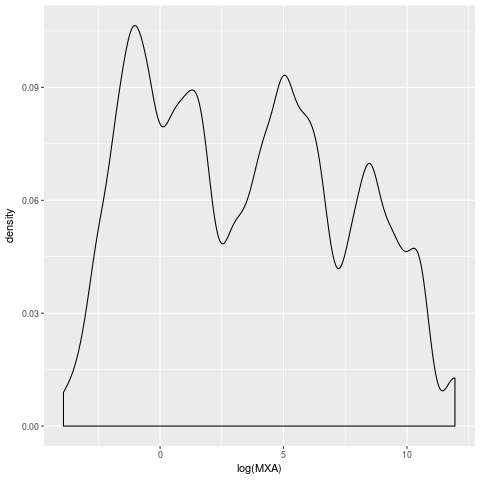

In [11]:
%%R
p = ggplot(final_t_df, aes(log(MXA))) + geom_density()
print(p)

In [12]:
%%R
print(head(final_t_df, 2))

  X3prime_model EffectiveLength Length Length_x Length_y      MXA      MXB
1             0         549.584    719      719      719 51.65911 1.258850
2             0         261.901    430      430      430 25.82955 0.629425
  NumReads     TPM added_bases count_3prime_g count_3prime_t fraction
1 23.73320 32.4282           0              0              0      0.1
2  8.26684 23.7030           0              0              0      0.1
  fraction_unique g_3prime   g_id gene_truth gene_truthMXB iteration
1       0.7979651    FALSE R1_101   77.48866      1.888275         0
2       0.6516291    FALSE R1_101   77.48866      1.888275         0
  non_unique_kmers quantifier t_3prime     t_id transcript_truth
1              139   sailfish    FALSE R1_101_1         51.65911
2              139   sailfish    FALSE R1_101_2         25.82955
  transcript_truthMXB unique_kmers       id difference absolute_difference
1            1.258850          549 R1_101_1 -0.3281932           0.3281932
2            

In [16]:
%%R
final_t_df['bin_fraction_unique'] = .bincode(include.lowest = TRUE,
    final_t_df[['fraction_unique']], breaks=seq(0,1.1,0.1))

final_t_df['bin_small_fraction_unique'] = .bincode(include.lowest = TRUE,
    final_t_df[['fraction_unique']], breaks=seq(0,1.1,0.02))

subsetted_final_t_df = final_t_df[(final_t_df['X3prime_model']==F & final_t_df['count_3prime_t']<=5),]
subsetted2_final_t_df = final_t_df[(final_t_df['X3prime_model']==T & final_t_df['count_3prime_t']<=5),]


/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: No summary function supplied, defaulting to `mean_se()

  warnings.warn(x, RRuntimeWarning)


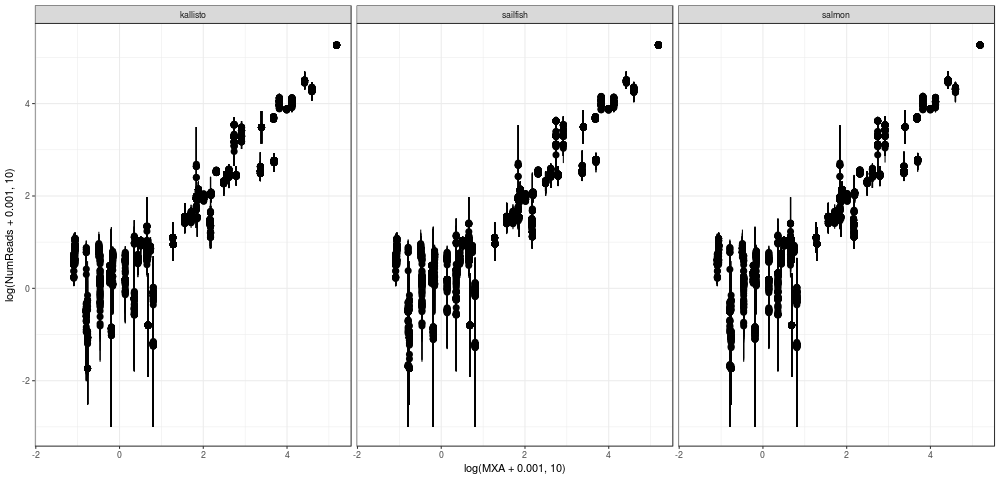

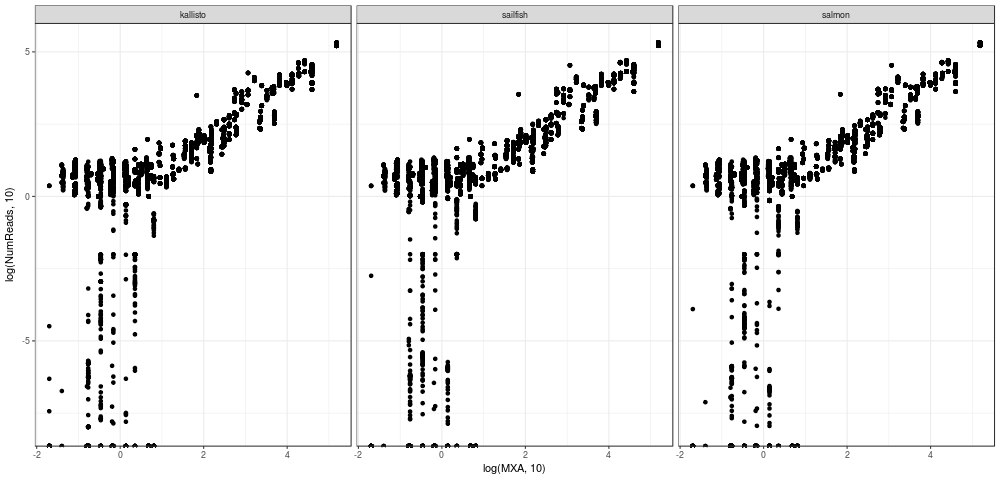

In [17]:
%%R -w 1000

p = ggplot(subsetted_final_t_df, aes(log(MXA+0.001,10), log(NumReads+0.001,10))) +
stat_summary() +
theme_bw() + facet_wrap(~quantifier)
print(p)

p = ggplot(subsetted_final_t_df, aes(log(MXA,10), log(NumReads,10))) + geom_point() +
theme_bw() + facet_wrap(~quantifier)
print(p)

In [18]:
%%R
print(log(2.52,10))

[1] 0.4014005


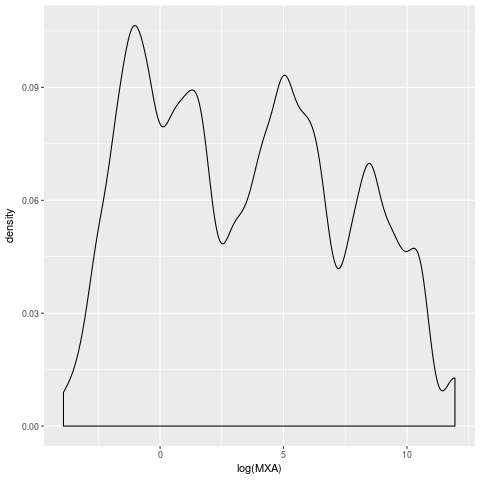

In [19]:
%%R
p = ggplot(final_t_df, aes(log(MXA))) + geom_density()
print(p)

/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: No summary function supplied, defaulting to `mean_se()

  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

  warnings.warn(x, RRuntimeWarning)


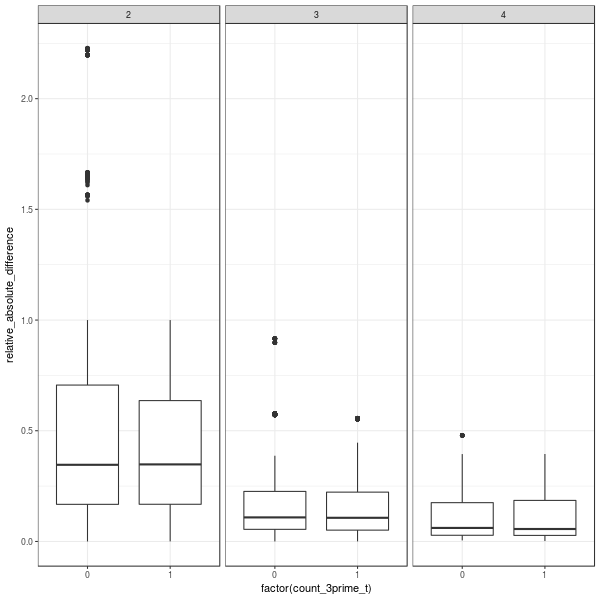

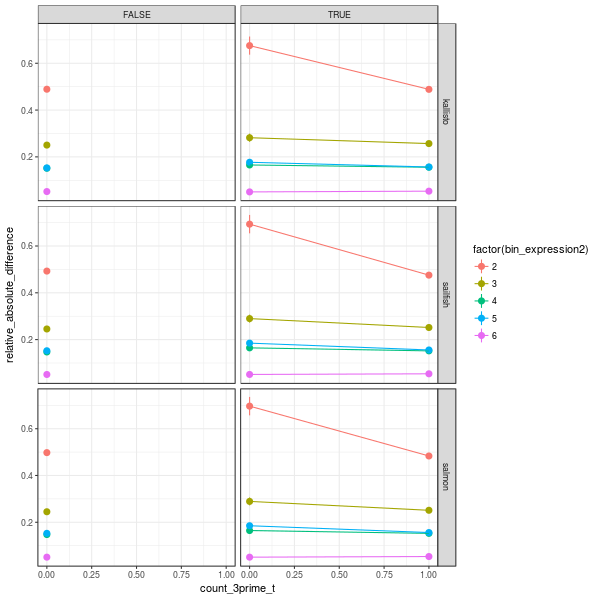

In [21]:


%%R -w 600 -h 600
subsetted_final_t_df['bin_expression1'] = .bincode(
    log(subsetted_final_t_df[['MXA']]), breaks=c(-10,0.5,3,5.5,100))

p = ggplot(subsetted_final_t_df[subsetted_final_t_df['bin_expression1']>1,],
           aes(factor(count_3prime_t), relative_absolute_difference)) +
geom_boxplot() +
facet_wrap(~bin_expression1) +
theme_bw()

print(p)

subsetted_final_t_df['bin_expression2'] = .bincode(
    log(subsetted_final_t_df[['MXA']]), breaks=c(-10,0.5,2,4,6,8,100))

p = ggplot(subsetted_final_t_df[subsetted_final_t_df['bin_expression2']>1,],
           aes(count_3prime_t, relative_absolute_difference)) +
stat_summary(aes(colour = factor(bin_expression2))) +
stat_summary(fun.y = mean, geom="line", aes(colour = factor(bin_expression2))) +
facet_grid(quantifier~g_3prime) +
theme_bw()

print(p)




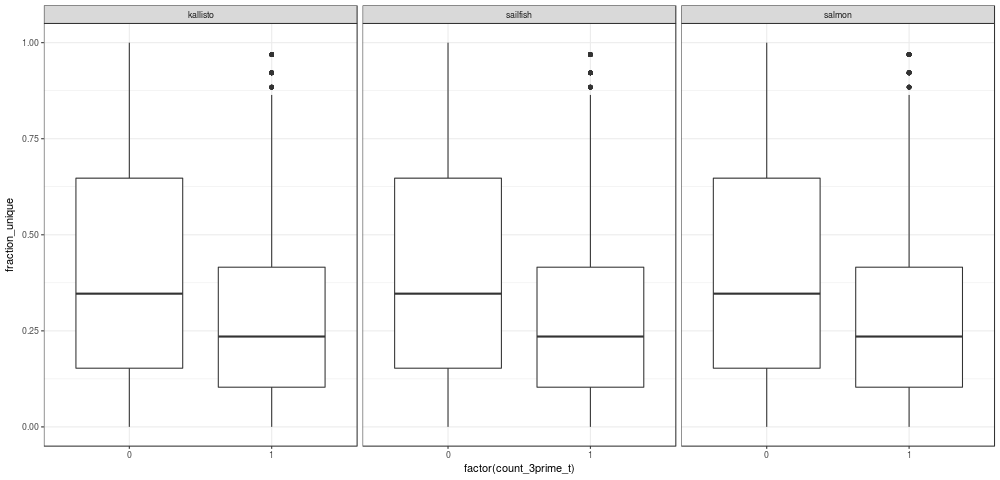

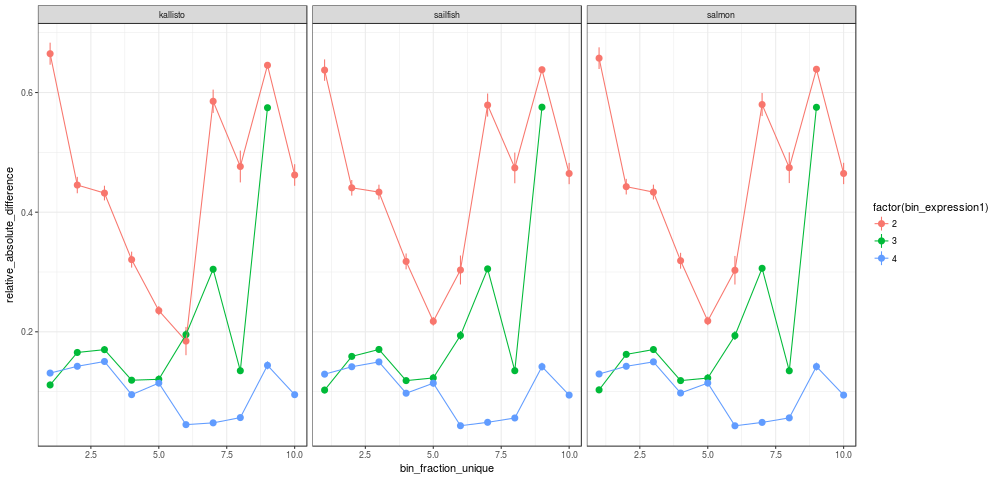

In [23]:
%%R -w 1000


p = ggplot(subsetted_final_t_df, aes(factor(count_3prime_t), fraction_unique)) +
geom_boxplot() +
theme_bw() +
facet_grid(.~quantifier)

print(p)

p = ggplot(subsetted_final_t_df[subsetted_final_t_df['bin_expression1']>1,],
           aes(bin_fraction_unique, relative_absolute_difference)) +
stat_summary(aes(colour = factor(bin_expression1))) +
stat_summary(fun.y = mean, geom="line", aes(colour = factor(bin_expression1))) +
theme_bw() +
facet_grid(.~quantifier)

print(p)

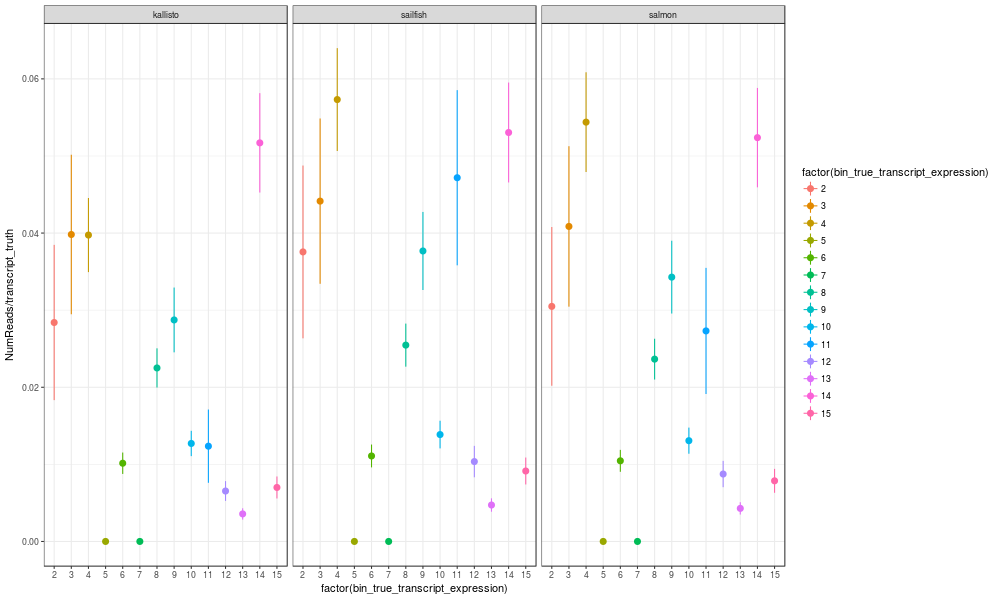

In [24]:
%%R -w 1000 -h 600
subsetted2_final_t_df['bin_true_transcript_expression'] = .bincode(
    log(subsetted2_final_t_df[['transcript_truth']]), c(-10,0,1,1.5,2,2.5,3,3.5,4,4.5,5.5,6,7,8,9,100))


p = ggplot(subsetted2_final_t_df[subsetted2_final_t_df$bin_true_transcript_expression > 1,],
                                 aes(factor(bin_true_transcript_expression), NumReads/transcript_truth)) +
stat_summary(aes(colour = factor(bin_true_transcript_expression))) +
stat_summary(fun.y = mean, geom="line", aes(colour = factor(bin_true_transcript_expression))) +
theme_bw() +
facet_grid(.~quantifier)

print(p)


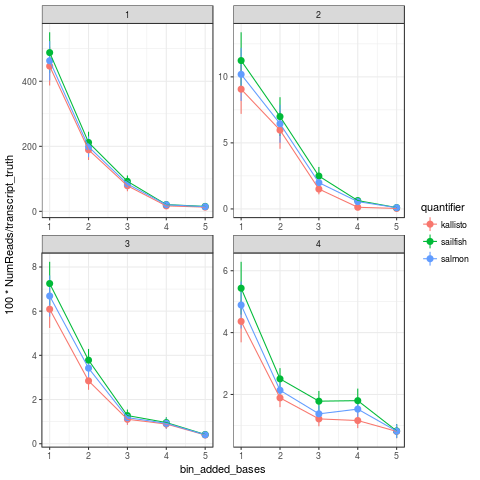

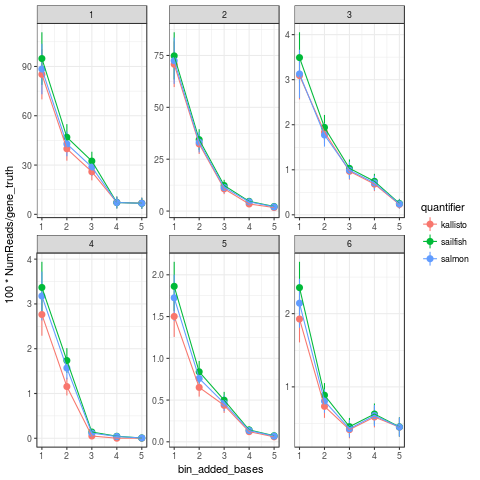

In [82]:
%%R

subsetted2_final_t_df['bin_added_bases'] = .bincode(
    subsetted2_final_t_df[['added_bases']], seq(0,1000,200))

subsetted2_final_t_df['bin_transcript_truth'] = .bincode(
    log(subsetted2_final_t_df[['transcript_truth']]), c(-10,0,3,5,100))

subsetted2_final_t_df['bin_gene_truth'] = .bincode(
    log(subsetted2_final_t_df[['gene_truth']]), c(-10,0,2,4,6,8,100))


p = ggplot(subsetted2_final_t_df,
           aes(bin_added_bases, 100*NumReads/transcript_truth,group = quantifier)) +
stat_summary(aes(colour = quantifier, group = quantifier)) +
stat_summary(fun.y = mean, geom="line", aes(colour = quantifier, group = quantifier)) +
theme_bw() +
facet_wrap(~bin_transcript_truth, scales = "free")

print(p)

p = ggplot(subsetted2_final_t_df,
           aes(bin_added_bases, 100*NumReads/gene_truth,group = quantifier)) +
stat_summary(aes(colour = quantifier, group = quantifier)) +
stat_summary(fun.y = mean, geom="line", aes(colour = quantifier, group = quantifier)) +
theme_bw() +
facet_wrap(~bin_gene_truth, scales = "free")

print(p)

  X3prime_model EffectiveLength Length Length_x Length_y         MXA
1             0         549.584    719      719      719   51.659107
2             0         261.901    430      430      430   25.829553
3             0        2369.470   1490     2539     1490    4.558156
5             0        1192.470   1362     1362     1362   72.930504
6             0        1584.470   1754     1754     1754  551.030474
7             0        1686.470   1856     1856     1856 4408.243792
          MXB   NumReads         TPM added_bases count_3prime_g count_3prime_t
1   1.2588501   23.73320   32.428200           0              0              0
2   0.6294250    8.26684   23.703000           0              0              0
3   0.8886001    2.11834    0.671346           0              1              1
5   0.0555375   95.53650   60.162200           0              1              0
6 429.6875000  814.08800  385.824000           0              0              0
7  53.7109375 5644.91000 2513.510000       

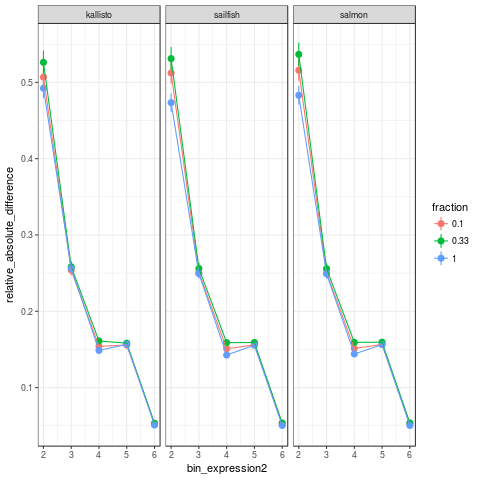

In [25]:
%%R
print(head(subsetted_final_t_df))

p = ggplot(subsetted_final_t_df[subsetted_final_t_df['bin_expression2']>1,],
           aes(bin_expression2, relative_absolute_difference)) +
stat_summary(aes(colour = fraction)) +
stat_summary(fun.y = mean, geom="line", aes(colour = fraction)) +
theme_bw() +
facet_grid(.~quantifier)

print(p)